In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint, GeometryCollection, MultiLineString
from shapely.ops import cascaded_union, linemerge
from shapely.geometry import LineString, LinearRing
from datetime import datetime, timedelta
import time
import warnings
import statsmodels.api as sm
import datetime
import math
from scipy.ndimage.interpolation import shift
import scipy.interpolate as si
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau
import xarray as xr
#warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

In [2]:
def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

In [3]:
#IN df_segs, a geodataframe of the line segments making up the fire front
#IN d, the length of the resulting perpindicular segments
#OUT 
def find_perp_outside_segments(df_segs,d):
     #get the start and end points of each line
    df_segs['x1'] =[list(df_segs['geometry'].iloc[ll].coords)[0][0] for ll in range(len(df_segs))]
    df_segs['y1'] =[list(df_segs['geometry'].iloc[ll].coords)[0][1] for ll in range(len(df_segs))]
    df_segs['x2'] =[list(df_segs['geometry'].iloc[ll].coords)[1][0] for ll in range(len(df_segs))]
    df_segs['y2'] =[list(df_segs['geometry'].iloc[ll].coords)[1][1] for ll in range(len(df_segs))]
    
    #get the midpoints
    df_segs['x_mid'] = (df_segs['x1']+df_segs['x2'])/2
    df_segs['y_mid'] = (df_segs['y1']+df_segs['y2'])/2
    
    #get the slopes and perp slope of each segment
    df_segs['m_line'] = (df_segs['y2']-df_segs['y1'])/(df_segs['x2']-df_segs['x1'])
    df_segs['m_perp'] = -1/df_segs['m_line']
    
    #get the inward and outward pointing perpindiculars
    df_segs['x_mid_plus'] = df_segs['x_mid']+(d/np.sqrt(1+(df_segs['m_perp']**2)))
    df_segs['y_mid_plus'] = (df_segs['m_perp']*(df_segs['x_mid_plus']-df_segs['x_mid'])) + df_segs['y_mid']
    df_segs['x_mid_minus'] = df_segs['x_mid']-(d/np.sqrt(1+(df_segs['m_perp']**2)))
    df_segs['y_mid_minus'] = (df_segs['m_perp']*(df_segs['x_mid_minus']-df_segs['x_mid'])) + df_segs['y_mid']
    
    #when m_line = 0 (just add d to the y direction)
    df_segs['x_mid_plus'][df_segs['m_line']==0] = df_segs['x_mid'][df_segs['m_line']==0]
    df_segs['x_mid_minus'][df_segs['m_line']==0] = df_segs['x_mid'][df_segs['m_line']==0]
    df_segs['y_mid_plus'][df_segs['m_line']==0] = df_segs['y_mid'][df_segs['m_line']==0]+d
    df_segs['y_mid_minus'][df_segs['m_line']==0] = df_segs['y_mid'][df_segs['m_line']==0]-d
    
    #turn them into points
    df_segs['plus_points'] = [Point(list(zip(df_segs['x_mid_plus'],df_segs['y_mid_plus']))[mm]) for mm in range(len(df_segs))]
    df_segs['minus_points'] = [Point(list(zip(df_segs['x_mid_minus'],df_segs['y_mid_minus']))[mm]) for mm in range(len(df_segs))]

    df_segs['x_outside'] = np.zeros(len(df_segs))
    df_segs['y_outside'] = np.zeros(len(df_segs))
    
    #check which points are in the polygons, drop those
    for xx in range(len(df_segs)):
        #print(perim['geometry'].iloc[0])
        if not perim['geometry'].iloc[0].contains(df_segs['plus_points'].iloc[xx]):
            #print(xx)
            df_segs['x_outside'].iloc[xx] = df_segs['x_mid_plus'].iloc[xx]
            df_segs['y_outside'].iloc[xx] = df_segs['y_mid_plus'].iloc[xx]
        if not perim['geometry'].iloc[0].contains(df_segs['minus_points'].iloc[xx]):
            df_segs['x_outside'].iloc[xx] = df_segs['x_mid_minus'].iloc[xx]
            df_segs['y_outside'].iloc[xx] = df_segs['y_mid_minus'].iloc[xx]

    perpindicular_segs = df_segs[['time','x_mid','y_mid','x_outside','y_outside','geometry']]
    perpindicular_segs = perpindicular_segs.rename_geometry('fireline_geometry') #save the fireline geom
    perpindicular_segs['x'] = perpindicular_segs['x_outside']-perpindicular_segs['x_mid']
    perpindicular_segs['y'] = perpindicular_segs['y_outside']-perpindicular_segs['y_mid']
    #add the outwrd pointing perp as the main tracked geometry
    perpindicular_segs['perpindicular_lines'] = [LineString(((perpindicular_segs['x_mid'].iloc[xx], perpindicular_segs['y_mid'].iloc[xx]),
                                         (perpindicular_segs['x_outside'].iloc[xx], perpindicular_segs['y_outside'].iloc[xx]))) 
                                             for xx in range(len(perpindicular_segs))] 
    perpindicular_segs = perpindicular_segs.set_geometry('perpindicular_lines')
    return perpindicular_segs

## Save Polygons/Generate Perpindiculars

In [ ]:
# perpindiculars are the same size!
test_fire_ids = [3525,3798,3763,3612,3482] #ABCDL order
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones, also ABCDL Order
#test_fire_ids=[3482]
#fire_incidents=['LAKE']
fires_2020_fireline = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='fireline')
fires_2020_perimeter = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='perimeter')
fires_2020_pix = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='newfirepix')

In [ ]:
for jj in range(len(test_fire_ids)):
    fire_name = fire_incidents[jj].lower().replace(' ','_')
    print(fire_name)
    fireline_case = fires_2020_fireline[fires_2020_fireline['fireID']==test_fire_ids[jj]]
    perimeter_case = fires_2020_perimeter[fires_2020_perimeter['fireID']==test_fire_ids[jj]]
    pix_case = fires_2020_pix[fires_2020_pix['fireID']==test_fire_ids[jj]]
    print(len(pix_case))
    print(len(perimeter_case))
    case_save = gpd.GeoDataFrame({'time':pix_case['time'], 
                                 'perimeter': perimeter_case['geometry'],
                                 'polygon':pix_case['geometry'],
                                 'fireline_split': gpd.GeoSeries(),
                                 'fireline_perpindicular':gpd.GeoSeries()})
    for ind in range(len(fireline_case)): # the output of this for loop shoud be a df with directional HDW
        fline = fireline_case.iloc[ind:ind+1] #fireline for the given timestep
        perim = perimeter_case.iloc[ind:ind+1] #perimeter for the given timestep
        pix = pix_case.iloc[ind:ind+1] #the polygon for the given time step (most similar to mine)

        geom = fline.iloc[0].geometry

        if geom==None:
            case_save['fireline_split'].iloc[ind] = None #Point()
            case_save['fireline_perpindicular'].iloc[ind] = None #Point()
            case_save['polygon'].iloc[ind] = None #Point()

            continue #FOR NOW, COME BACK AND ADD A ROW TO THE FINAL OUTPUT WHEN IT'S DECIDED WHAT WILL GO THERE
        elif geom.geom_type=='LineString':
            segs_flat = segments(geom)
        elif geom.geom_type=='MultiLineString':
            segs_list = []
            for line in geom: #if a multipolygon
                segs_list.append(segments(line))
            segs_flat = [num for sublist in segs_list for num in sublist]
        segs = gpd.GeoDataFrame({'ind':np.arange(0,len(segs_flat)),
                                 'time': np.repeat(fline.time,len(segs_flat)),
                                'geometry':segs_flat})
        segs = segs[segs.length>0.0005]

        perp_segs = find_perp_outside_segments(segs,0.005)
        #print(MultiLineString(perp_segs['fireline_geometry'].values))
        #print(type(perp_segs['fireline_geometry'].values))
        case_save['fireline_split'].iloc[ind] = MultiLineString(perp_segs['fireline_geometry'].values)
        case_save['fireline_perpindicular'].iloc[ind] = MultiLineString(perp_segs['perpindicular_lines'].values)
    #case_save = case_save.set_geometry('fireline_perpindicular')
    case_save_polygon = gpd.GeoDataFrame(case_save[['time','polygon']], geometry='polygon')
    #case_save_perimeter = gpd.GeoDataFrame(case_save, geometry='fireline_perpindicular')
    #case_save_split = gpd.GeoDataFrame(case_save, geometry='fireline_perpindicular')
    #case_save_perpindicular = gpd.GeoDataFrame(case_save, geometry='fireline_perpindicular')

    print(case_save_polygon)
    #case_save_polygon.to_file('./fire_polygons/'+fire_name+'_Chen_Twice_Daily_Polygons.geojson', driver='GeoJSON') #daily averages
    case_save.to_csv('./fire_polygons/'+fire_name+'_Chen_Poly_Perim_Perp.csv',index=False)

In [ ]:
test = pd.read_csv('./fire_polygons/TEST.csv')
test = test.dropna()
#print(test)
#print(type(test['polygon'].iloc[2]))

for c in ['perimeter','polygon','fireline_split','fireline_perpindicular']:
    print(c)
    test[c]=test[c].apply(shapely.wkt.loads)
    

test['time'] = test['time'].astype('datetime64')
   
test = test.set_index('time').resample('12H').asfreq()
print(test)

In [ ]:
df = pd.DataFrame({'prop1' : ['Val1','Val2','Val3']})
geometry = [Point(),Point(),Point()]
# convert the DataFrame to a GeoDataFrame
geo_df = gpd.GeoDataFrame(df,geometry=geometry)
print(geo_df)

In [ ]:
print(type(case_save['perimeter'].iloc[0]))
print(type(case_save['polygon'].iloc[0]))
print(type(case_save['fireline_split'].iloc[0]))
print(type(case_save['fireline_perpindicular'].iloc[0]))

## Plot 2020 and test case polygons selection

In [ ]:
#plot all of the 2020 fires
fires_2020_perimeter = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='perimeter')
fires_2020_fireline = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='fireline')
print(np.unique(fires_2020_perimeter['fireID'].values))

fig,ax=plt.subplots(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())
fires_2020_perimeter.plot(ax=ax, column='fireID', legend=True)
ax.coastlines()
ax.gridlines()
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
ax.set_extent([-126, -114, 32, 42.5])
plt.show()

In [ ]:
#filter the 2020 fires by test fire
test_fire_ids = [3525,3798,3763,3612,3482]

test_fires_2020_perimeter = fires_2020_perimeter[fires_2020_perimeter['fireID'].isin(test_fire_ids)]

fig,ax=plt.subplots(figsize=(15,15))
ax = plt.axes(projection=ccrs.PlateCarree())
test_fires_2020_perimeter.plot(ax=ax, column='fireID', legend=True)
ax.coastlines()
ax.gridlines()
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
ax.set_extent([-126, -114, 32, 42.5])
plt.show()

In [ ]:
# filter the 2020 fires based on fire location
fire_incidents = ['AUGUST COMPLEX','BOBCAT', 'DOLAN','CREEK', 'LAKE'] #only california ones
#fire_incidents=['LAKE']
path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12

for ii in range(len(fire_incidents)):
    fire_name = fire_incidents[ii].lower().replace(' ','_')
    polygons = gpd.read_file(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    
    #extract the latitude and longitude of the fire (start location from Laura)
    fire_lat = polygons['Lat Fire'].iloc[0]
    fire_lon = polygons['Lon Fire'].iloc[0]

    #which poly centroid is closest?
    closest_poly_centroid= np.argmin(((fires_2020_perimeter['clat'].values-fire_lat)**2)+((fires_2020_perimeter['clon'].values-fire_lon)**2))
    closest_poly_id = fires_2020_perimeter['fireID'].iloc[closest_poly_centroid]
    print(closest_poly_id)
    fire_2020_perimeter_sub = fires_2020_perimeter[fires_2020_perimeter['fireID']==closest_poly_id].reset_index()
    fire_2020_fireline_sub = fires_2020_fireline[fires_2020_fireline['fireID']==closest_poly_id].reset_index()
    
    #plot final perimeter with winds and fireline
    ind = len(fire_2020_perimeter_sub)-1
    print(ind)

    #get the time of the polygon
    time = fire_2020_perimeter_sub['time'][ind]
    timestring = pd.to_datetime(time).strftime('%Y%m%d%H')

    #get the bounds of the polygon|
    fire_poly = fire_2020_perimeter_sub.loc[[ind],'geometry']
    fire_line = fire_2020_fireline_sub.loc[[ind],'geometry']
    fire_poly_bounds = fire_poly.bounds

    #open the wind data
    """hrrr= xr.open_dataset('./pygraf/Processed_HRRR_'+timestring+'.nc')

    #subset the wind data
    grid_yt_sel, grid_xt_sel = np.where((hrrr['grid_lont']<fire_poly_bounds['maxx'].values)&
                                    (hrrr['grid_lont']>fire_poly_bounds['minx'].values)&
                                    (hrrr['grid_latt']<fire_poly_bounds['maxy'].values)&
                                    (hrrr['grid_latt']>fire_poly_bounds['miny'].values))
    hrrr = hrrr.sel(grid_yt=grid_yt_sel,grid_xt=grid_xt_sel)
    """
    #plot a polygon and its perimeters, wind quiver plot
    fig,ax=plt.subplots(figsize=(15,15))
    #plt.quiver(hrrr['grid_lont'], hrrr['grid_latt'], hrrr['uwind_10m'], hrrr['vwind_10m'])
    fire_poly.to_crs(epsg=3347).plot(ax=ax, color='r')
    polygons.plot(ax=ax, color='b')
    #fire_line.plot(ax=ax, color='k', linewidth=4)
    plt.title(fire_incidents[ii])
    plt.show()

In [ ]:
print(fires_2020_perimeter.columns)

## Aggregate the Chen Fireline Info

In [ ]:
#old way of doing fireline aggregation (October 26)
test_fire_ids = [3525,3798,3763,3612,3482] #ABCDL order
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones, also ABCDL Order
fires_2020_fireline = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='fireline')
start_time=12


for ii in range(len(test_fire_ids)):
    fire_name = fire_incidents[ii].lower().replace(' ','_')
    fireline = fires_2020_fireline[fires_2020_fireline['fireID']==test_fire_ids[ii]].set_index('time') #set time as index
    fireline.index = pd.to_datetime(fireline.index) #make sure index is right type for resampling
    
    fireline_resampled = fireline.resample('24H', base = start_time).asfreq() #resample to the 12Z day
    fireline_resampled['day'] = fireline_resampled.index #add a day column (to dissolve along later)
    fireline_resampled = fireline_resampled.resample('12H', base=start_time).pad() #downsample to 12H frequency again

    inds_fill = np.where(fireline.index.isin(fireline_resampled.index))[0] #grab the rows in fireline to fill in
    inds_grab = np.where(fireline_resampled.index.isin(fireline.index))[0] #grab the rows of fireline_resample with which to fill

    #add the day column to fireline...
    fireline['day'] = np.zeros(len(fireline))
    fireline['day'].iloc[inds_fill] = fireline_resampled['day'].iloc[inds_grab]
    if fireline['day'].iloc[len(fireline)-1] ==0: #...taking care to fill in missing days that the resampler misses
        fireline['day'].iloc[len(fireline)-1] = fireline['day'].iloc[len(fireline)-2]


    fireline = fireline.reset_index()
    #now the fireline should have 12Z days associated with them, ok now we need to pick the 0Z ones
    #indz_0z = np.arange(0,len(fireline),2)
    fireline['hours'] = [int(fireline['time'].iloc[jj].strftime('%H')) for jj in range(len(fireline))]
    fireline=fireline.to_crs(epsg=3347)
    fireline_afternoon= fireline.loc[fireline['hours']==0]
    fireline_morning = fireline.loc[fireline['hours']==12]
    print(len(fireline_afternoon),len(fireline_morning))
    
    """ #fireline_save = pd.DataFrame({'day':fireline_afternoon['day'].values,
    #                             'afternoon_length': fireline_afternoon.length.values})
    
    fireline_save = pd.DataFrame({'day':fireline_morning['day'].values,
                                 'morning_length': fireline_morning.length.values})
    print(fireline_save)
    fireline_save.to_csv('./fire_features/'+fire_name+'_Daily_MORNING_FIRELINE_'+str(start_time)+'Z_day_start.csv') #daily averages
    #print(fireline.length)"""

In [ ]:
#New way of doing fireline aggregation (November 7)
test_fire_ids = [3525,3798,3763,3612,3482] #ABCDL order
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones, also ABCDL Order
fires_2020_fireline = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='fireline')
start_time=12


for ii in range(len(test_fire_ids)):
    fire_name = fire_incidents[ii].lower().replace(' ','_')
    fireline = fires_2020_fireline[fires_2020_fireline['fireID']==test_fire_ids[ii]].set_index('time') #set time as index
    fireline.index = pd.to_datetime(fireline.index) #make sure index is right type for resampling
    fireline['hours'] = [int(pd.to_datetime(fireline.index.values[jj]).strftime('%H')) for jj in range(len(fireline))]    
    
    
    fireline_resampled = fireline.resample('24H', base = start_time).asfreq() #resample to the 12Z day
    fireline_resampled['day'] = fireline_resampled.index #add a day column (to track the )
    fireline_resampled = fireline_resampled.resample('12H', base=start_time).pad() #downsample to 12H frequency again

    fireline['day'] = fireline_resampled['day']
    fireline = fireline.reset_index()
    print(fireline)
    fireline_morning = fireline[fireline['hours']==12]
    fireline_morning['morning_length'] = fireline_morning.length.values
    fireline_afternoon = fireline[fireline['hours']==0]
    fireline_afternoon['afternoon_length'] = fireline_afternoon.length.values
    #print(fireline_morning)
    #print(fireline_afternoon)
    
    merged = fireline_morning.merge(fireline_afternoon,how='outer', left_on='day', right_on='day',suffixes=('_morning', '_afternoon'))
    merged_save = merged[['day','time_morning','time_afternoon','morning_length','afternoon_length']].sort_values(by='day')
    merged_save['total_length'] = merged_save['morning_length']+merged_save['afternoon_length']
    print(merged_save)
    merged_save.to_csv('./fire_features/'+fire_name+'_Daily_FIRELINE_'+str(start_time)+'Z_day_start.csv') #daily averages


## Look into splitting one line into its component straight lines

In [ ]:
#first try, perpindiculars came out to different lengths
test_fire_ids = [3525,3798,3763,3612,3482] #ABCDL order
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones, also ABCDL Order
fires_2020_fireline = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='fireline')
fires_2020_perimeter = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='perimeter')

start_time=12


fireline_lake = fires_2020_fireline[fires_2020_fireline['fireID']==test_fire_ids[4]]
perimeter_lake = fires_2020_perimeter[fires_2020_perimeter['fireID']==test_fire_ids[4]]

for ind in range(1):#len(fireline_lake)):
    fline = fireline_lake.iloc[ind:ind+1]
    perim = perimeter_lake.iloc[ind:ind+1]
    geom = fline.iloc[0].geometry
    if geom==None:
        continue
        
    segs_list = []
    for line in geom:
        segs_list.append(segments(line))

    segs_flat = [num for sublist in segs_list for num in sublist]


    segs = gpd.GeoDataFrame({'ind':np.arange(0,len(segs_flat)),
                            'geometry':segs_flat})
    segs = segs[segs.length>0.001]
    
    x1=np.zeros(len(segs))
    y1=np.zeros(len(segs))
    x2=np.zeros(len(segs))
    y2=np.zeros(len(segs))
    for ll in range(len(segs)):
        #print(list(segs_gdf['geometry'].iloc[ll].coords)[1][0])
        x1[ll]=list(segs['geometry'].iloc[ll].coords)[0][0]
        y1[ll]=list(segs['geometry'].iloc[ll].coords)[0][1]
        x2[ll]=list(segs['geometry'].iloc[ll].coords)[1][0]
        y2[ll]=list(segs['geometry'].iloc[ll].coords)[1][1]
        
    segs['x1'] =x1
    segs['y1'] =y1
    segs['x2'] =x2
    segs['y2'] =y2
    
    segs['x_mid'] = (segs['x1']+segs['x2'])/2
    segs['y_mid'] = (segs['y1']+segs['y2'])/2
    
    segs['m_line'] = (segs['y2']-segs['y1'])/(segs['x2']-segs['x1'])
    segs['m_perp'] = -1/segs['m_line']
    
    
    d=0.001 #length of perpindicular segment
    segs['a'] = (1+(segs['m_perp']**2))
    segs['b'] = -2*segs['a']*segs['x_mid']
    segs['c'] = (((segs['x_mid'])**2) - (d**2))*segs['a']
    
    segs['y_mid_plus'] = (segs['m_perp']*(segs['x_mid_plus']-segs['x_mid']))+segs['y_mid']

    segs['x_mid_minus'] = ((-1*segs['b'])-np.sqrt((segs['b']**2)-(4*segs['a']*segs['c'])))/(2*segs['a'])
    segs['y_mid_minus'] = (segs['m_perp']*(segs['x_mid_minus']-segs['x_mid']))+segs['y_mid']

    centroid_lat = perim['clat'].values
    centroid_lon = perim['clon'].values
    
    segs['dist_mid_plus'] = np.sqrt(((segs['x_mid_plus']-centroid_lon)**2)+((segs['y_mid_plus']-centroid_lat)**2))
    segs['dist_mid_minus'] = np.sqrt(((segs['x_mid_minus']-centroid_lon)**2)+((segs['y_mid_minus']-centroid_lat)**2))
    #print(segs_gdf)
    #print(segs)
    
    perp_segs_plus = segs[['x_mid','y_mid','x_mid_plus','y_mid_plus','dist_mid_plus']]
    perp_segs_plus['geometry'] = [LineString(((perp_segs_plus['x_mid'].iloc[xx], perp_segs_plus['y_mid'].iloc[xx]),
                                             (perp_segs_plus['x_mid_plus'].iloc[xx], perp_segs_plus['y_mid_plus'].iloc[xx]))) 
                                             for xx in range(len(perp_segs_plus))]
    perp_segs_plus=perp_segs_plus.set_geometry('geometry')
    
    perp_segs_minus = segs[['x_mid','y_mid','x_mid_minus','y_mid_minus','dist_mid_minus']]
    perp_segs_minus['geometry'] = [LineString(((perp_segs_minus['x_mid'].iloc[xx], perp_segs_minus['y_mid'].iloc[xx]),
                                             (perp_segs_minus['x_mid_minus'].iloc[xx], perp_segs_minus['y_mid_minus'].iloc[xx]))) 
                                             for xx in range(len(perp_segs_plus))]
    perp_segs_minus=perp_segs_minus.set_geometry('geometry')
    
    
    fig,ax=plt.subplots(figsize=(15,15))
    fline.plot(ax=ax,linewidth=6,alpha=0.5)
    perim.plot(ax=ax,color='r',alpha=0.5)
    plt.scatter(perim['clon'],perim['clat'])
    segs.plot(ax=ax,column='m_line',linewidth=2,legend=True,cmap='tab20_r')
    perp_segs_plus['geometry'].plot(ax=ax)
    perp_segs_minus['geometry'].plot(ax=ax)

    plt.title(str(fline['time'].iloc[0]))
    plt.show()

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent 

          minx       miny        maxx       maxy
23 -118.600756  34.608103 -118.440179  34.740106
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 25, grid_y: 1058, grid_yt: 25)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 261 262 263 259 260 ... 262 263 264 260
  * grid_yt              (grid_yt) int64 457 457 457 458 458 ... 461 461 461 462
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.5 -118.5 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.61 34.62 ... 34.76 34.74
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gr

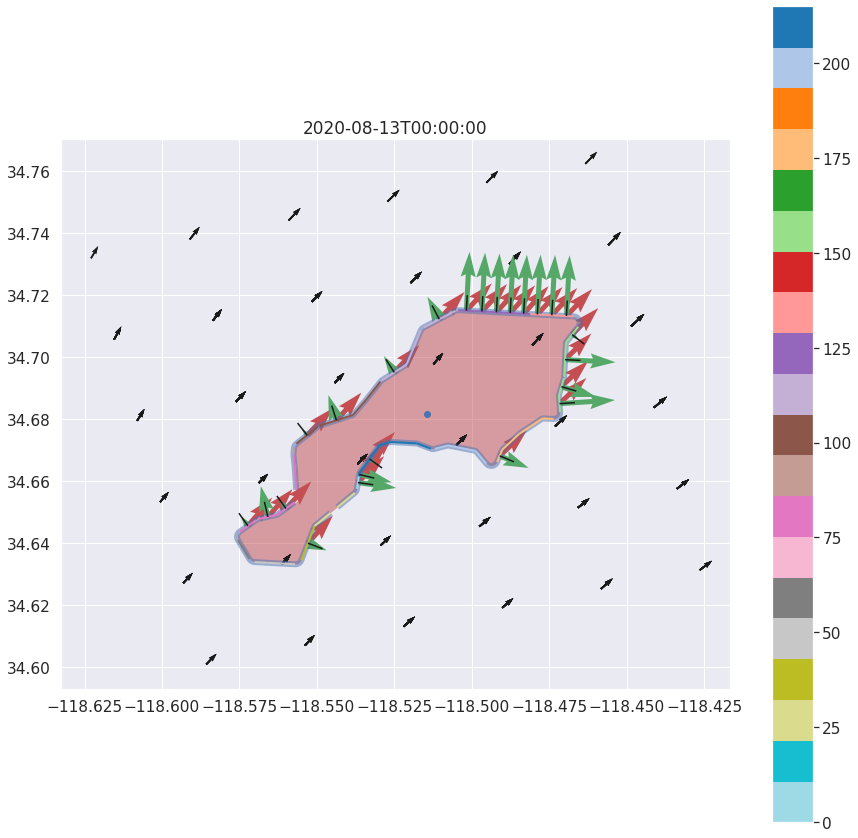

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
24 -118.600756  34.604723 -118.440179  34.740106
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 26, grid_y: 1058, grid_yt: 26)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 260 261 262 263 259 ... 262 263 264 260
  * grid_yt              (grid_yt) int64 457 457 457 457 458 ... 461 461 461 462
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.5 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.61 34.61 ... 34.76 34.74
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gr

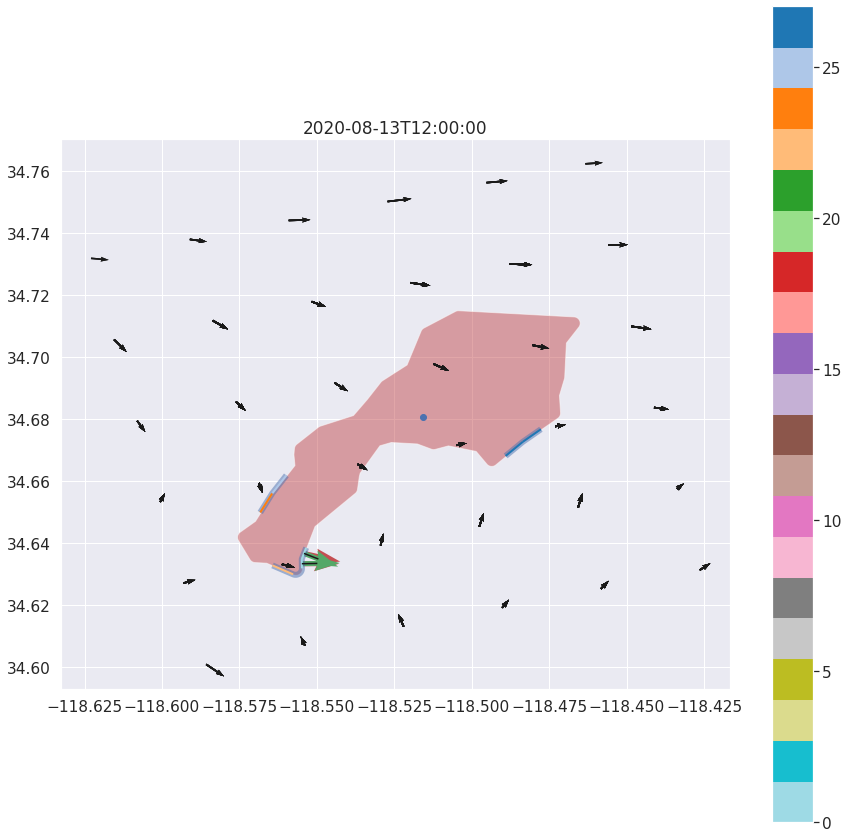

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
26 -118.600756  34.604723 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 29, grid_y: 1058, grid_yt: 29)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 260 261 262 263 259 ... 260 261 262 263
  * grid_yt              (grid_yt) int64 457 457 457 457 458 ... 462 462 462 462
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.5 ... -118.5
    grid_latt            (grid_yt, grid_xt) float32 34.61 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gr

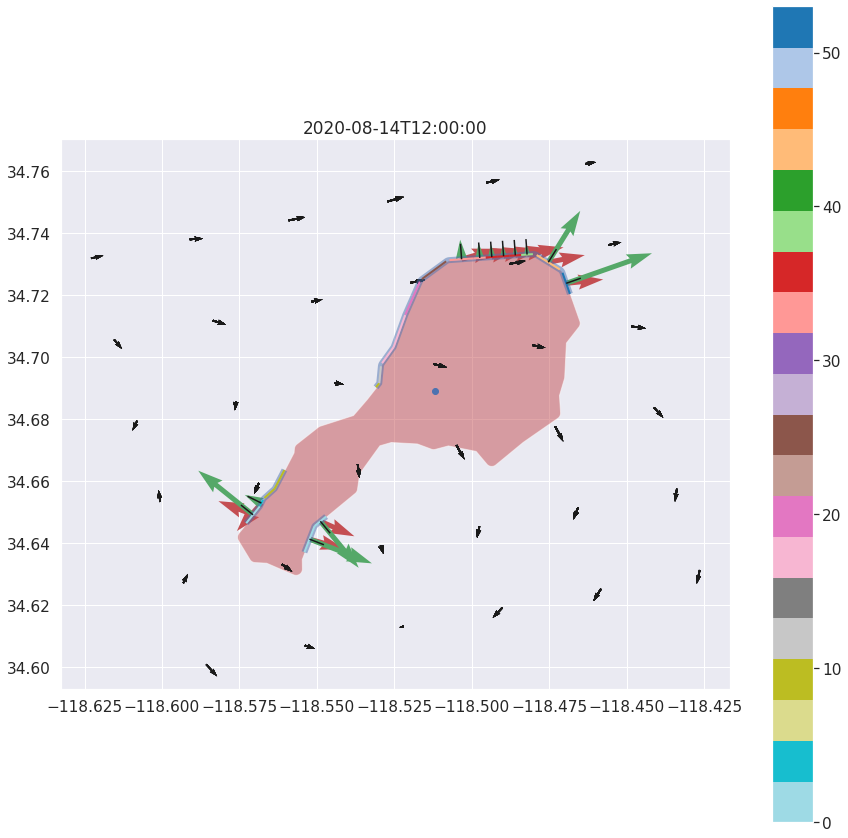

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
27 -118.605275  34.604723 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 29, grid_y: 1058, grid_yt: 29)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 260 261 262 263 259 ... 260 261 262 263
  * grid_yt              (grid_yt) int64 457 457 457 457 458 ... 462 462 462 462
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.5 ... -118.5
    grid_latt            (grid_yt, grid_xt) float32 34.61 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gr

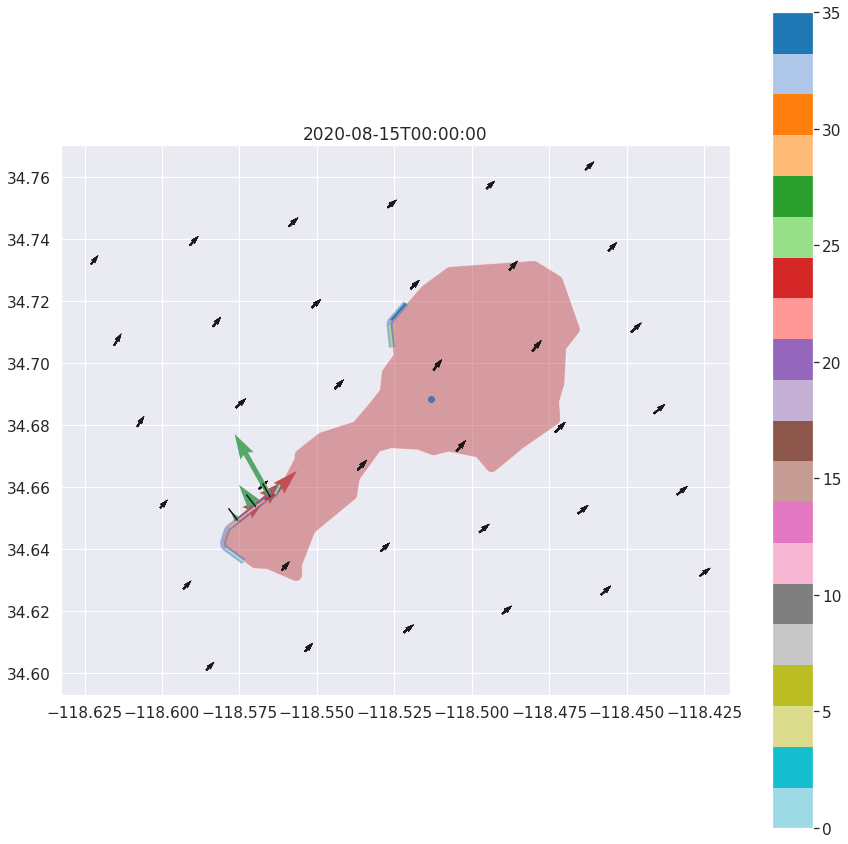

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
28 -118.621592  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 32, grid_y: 1058, grid_yt: 32)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 260 261 262 263
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 462
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.5
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

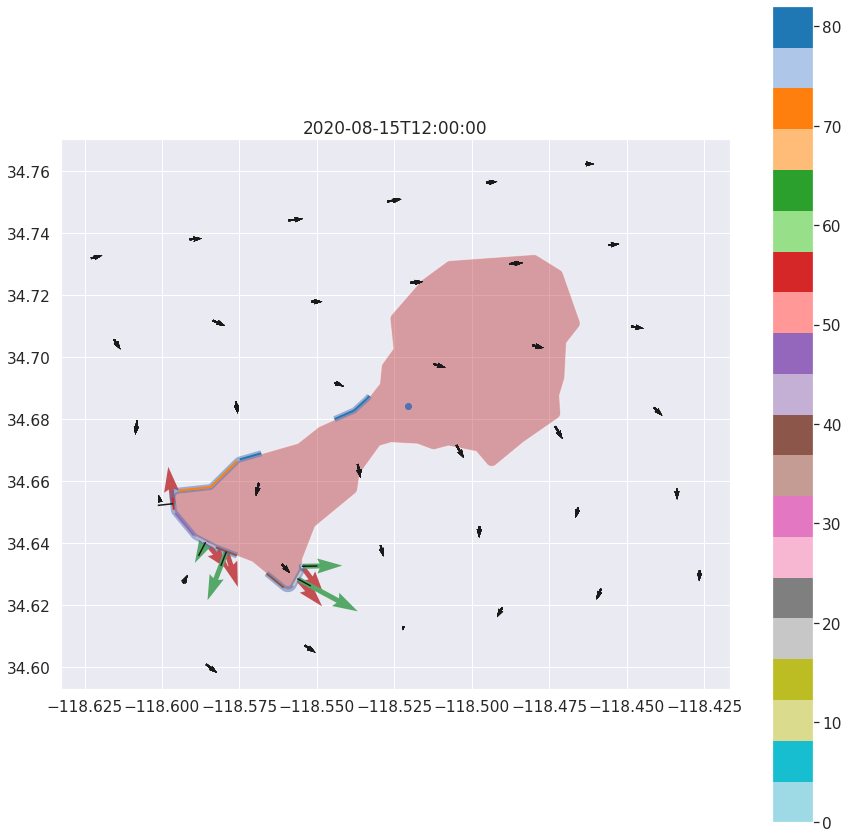

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
29 -118.621592  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 32, grid_y: 1058, grid_yt: 32)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 260 261 262 263
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 462
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.5
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

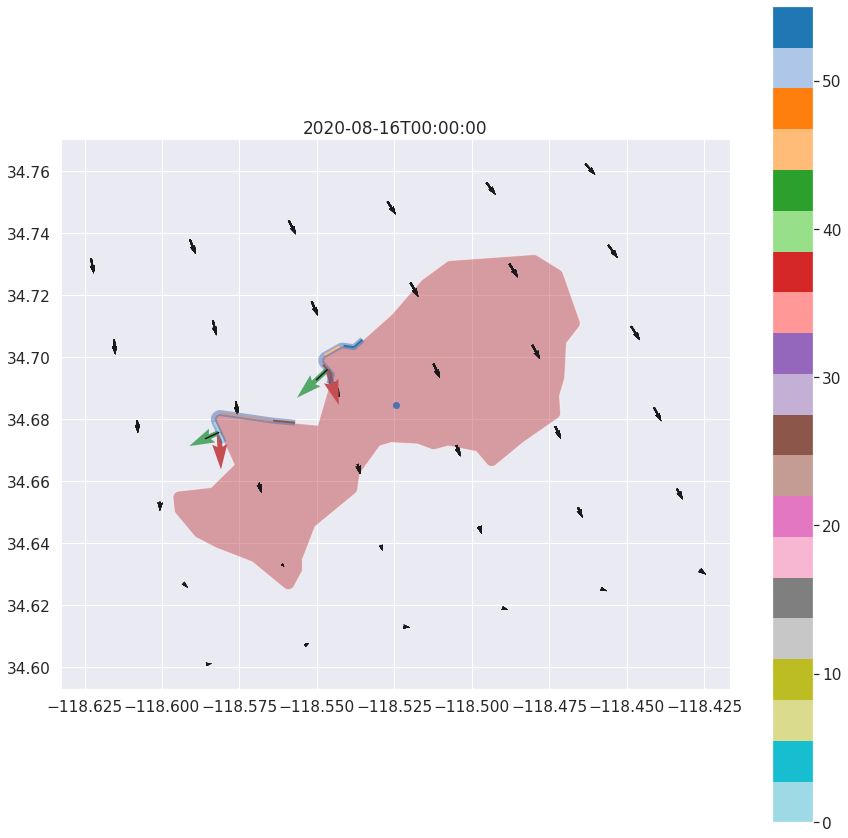

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
30 -118.621592  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 32, grid_y: 1058, grid_yt: 32)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 260 261 262 263
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 462
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.5
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=34,35 m=1024 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=33,36 m=1024 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the

0.09189411444558832


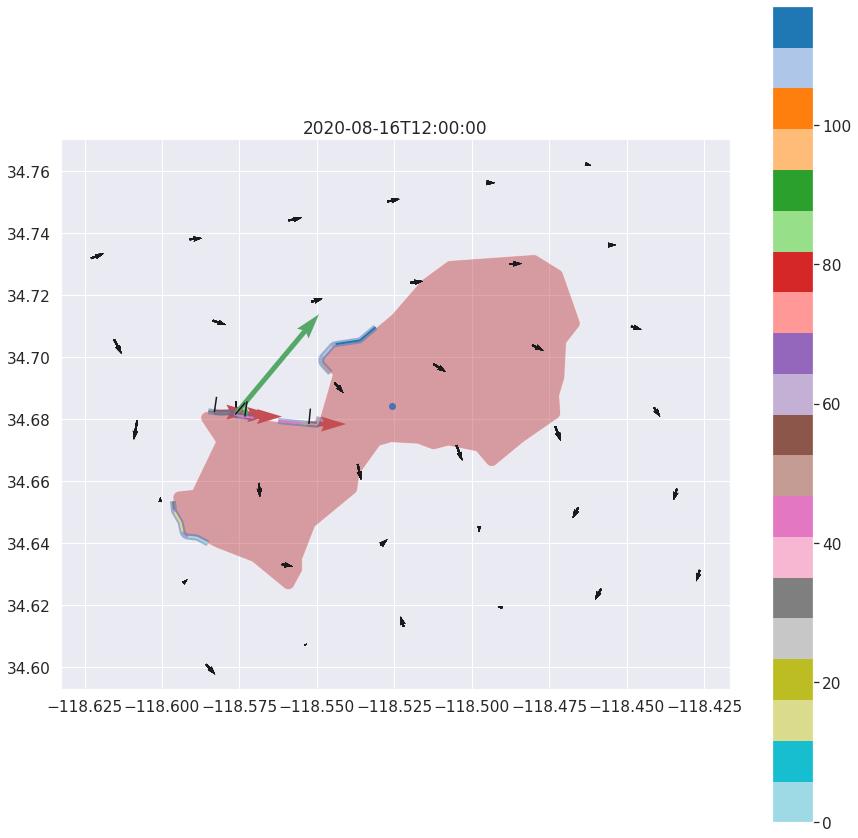

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
31 -118.622957  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 33, grid_y: 1058, grid_yt: 33)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 260 261 262 263
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 462
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.5
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=37,34 m=1089 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


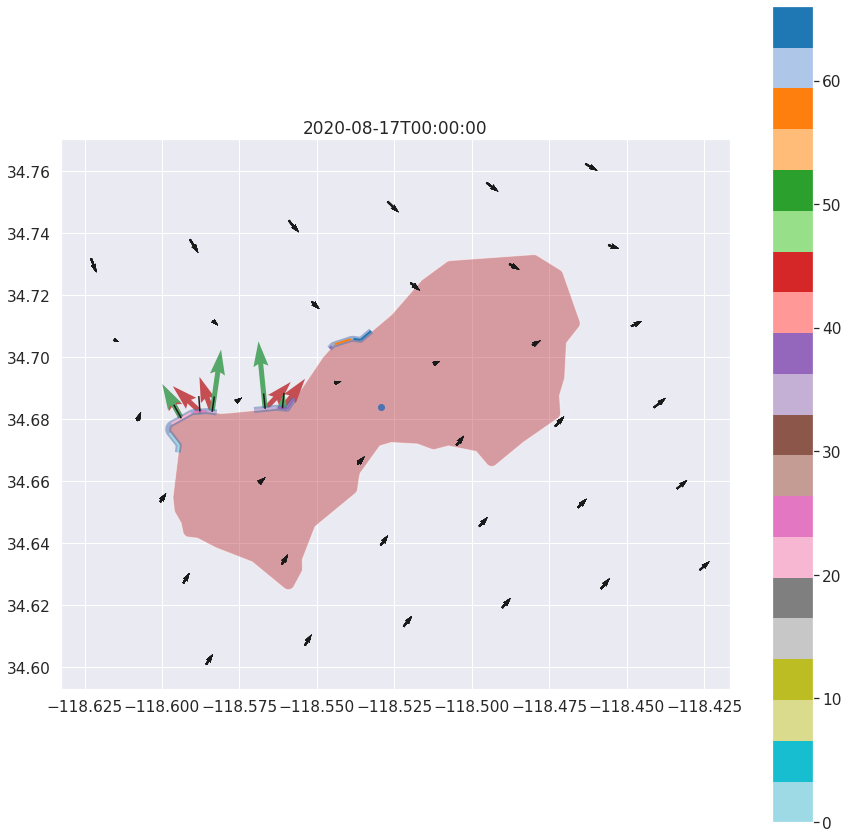

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/pytho

          minx       miny        maxx       maxy
32 -118.622957  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 33, grid_y: 1058, grid_yt: 33)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 260 261 262 263
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 462
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.5
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:670: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


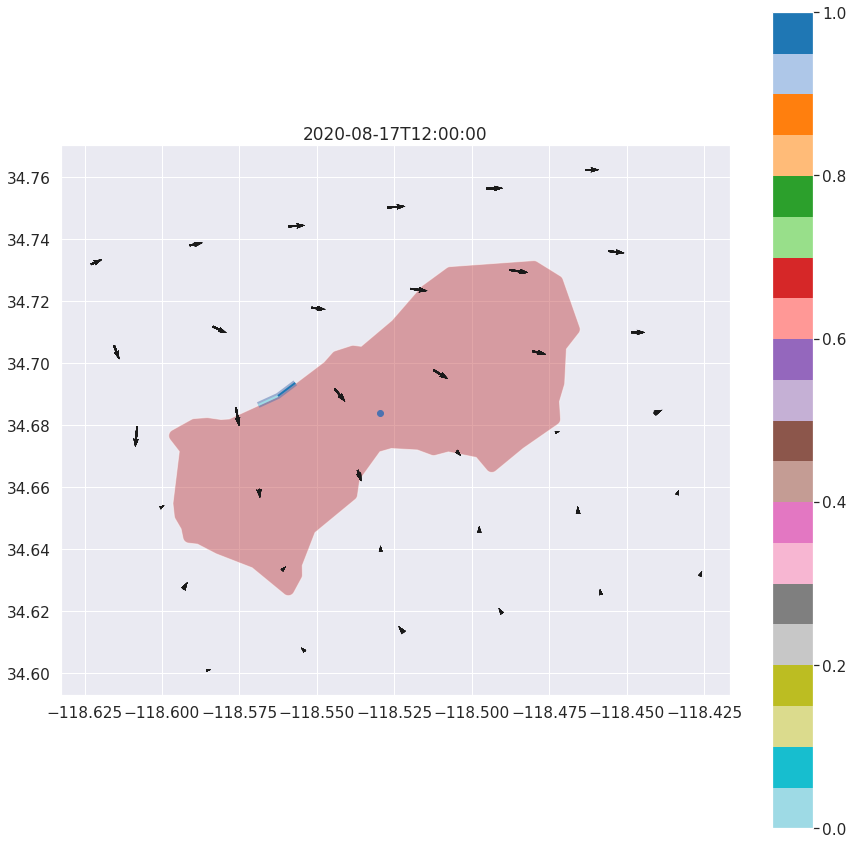

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
33 -118.650774  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 38, grid_y: 1058, grid_yt: 38)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 261 262 263 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.78 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

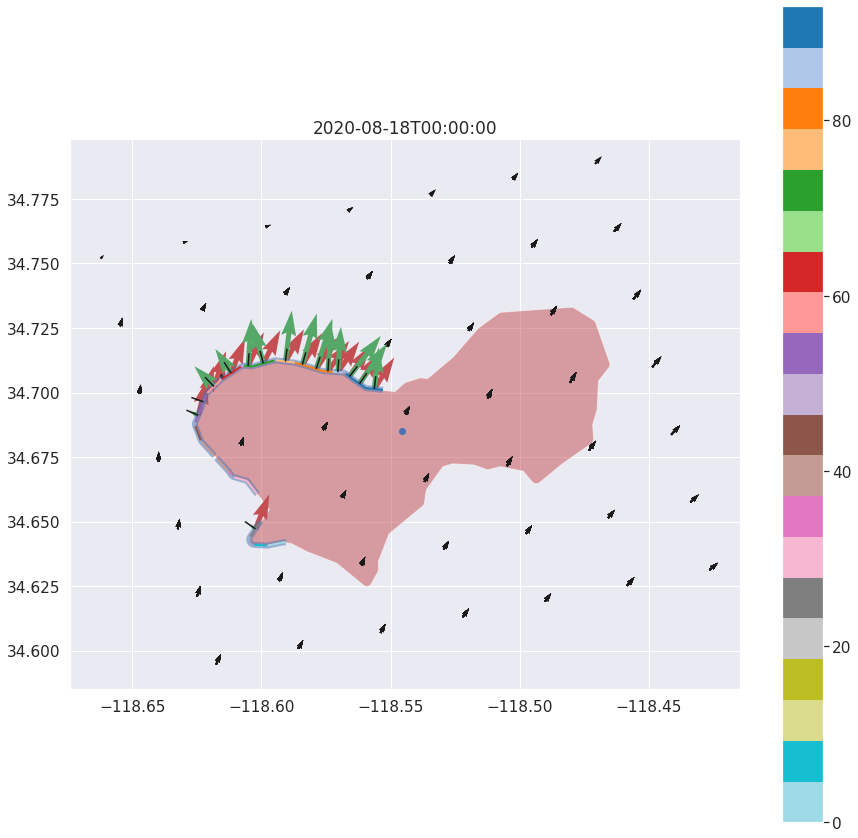

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
34 -118.650774  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 38, grid_y: 1058, grid_yt: 38)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 261 262 263 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.78 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=41,40 m=1444 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=42,39 m=1444 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/i

1.4035298036807513


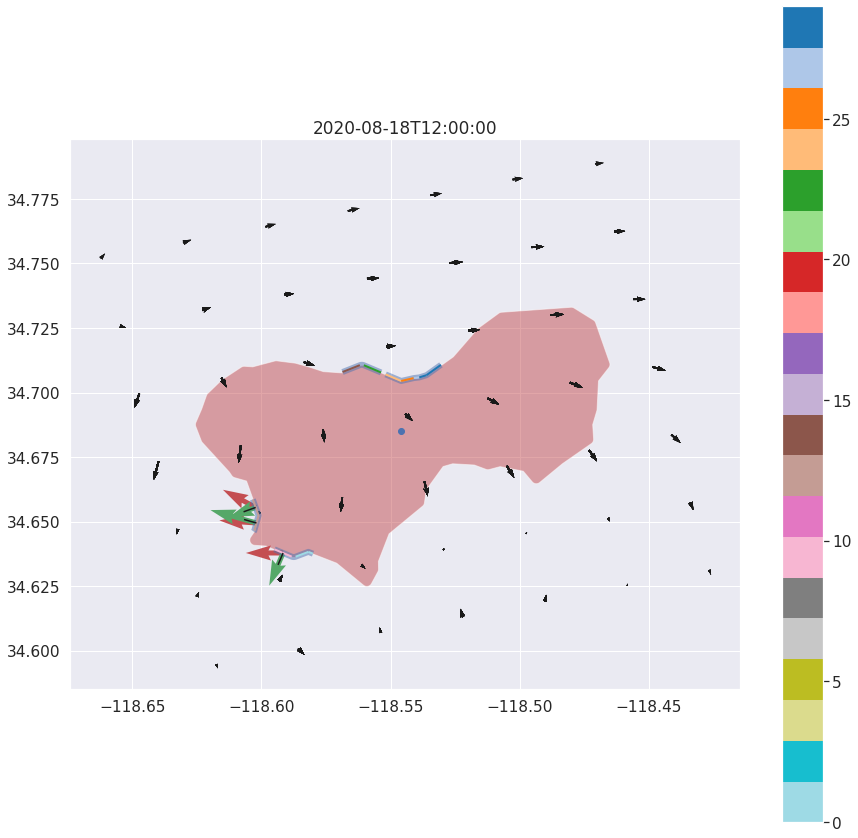

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
35 -118.658132  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 40, grid_y: 1058, grid_yt: 40)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 261 262 263 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.78 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=40,45 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.0


/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:686: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:686: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


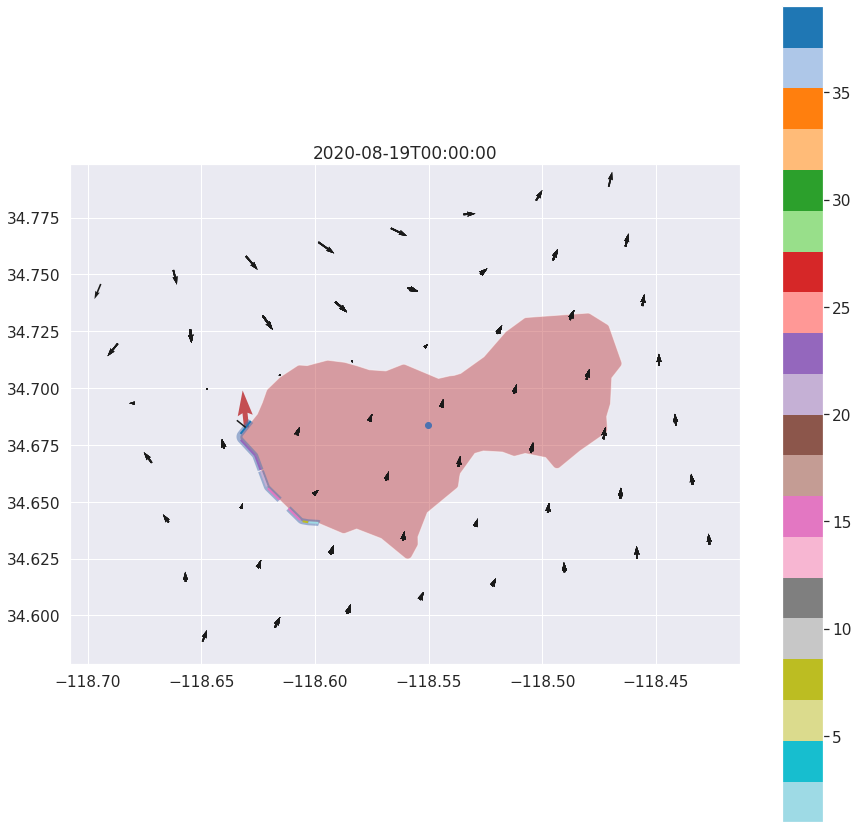

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

         minx       miny        maxx       maxy
36 -118.65814  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 40, grid_y: 1058, grid_yt: 40)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 261 262 263 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.78 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, grid_

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=40,45 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=1,1 nx,ny=11,10 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

0.031030140885477897


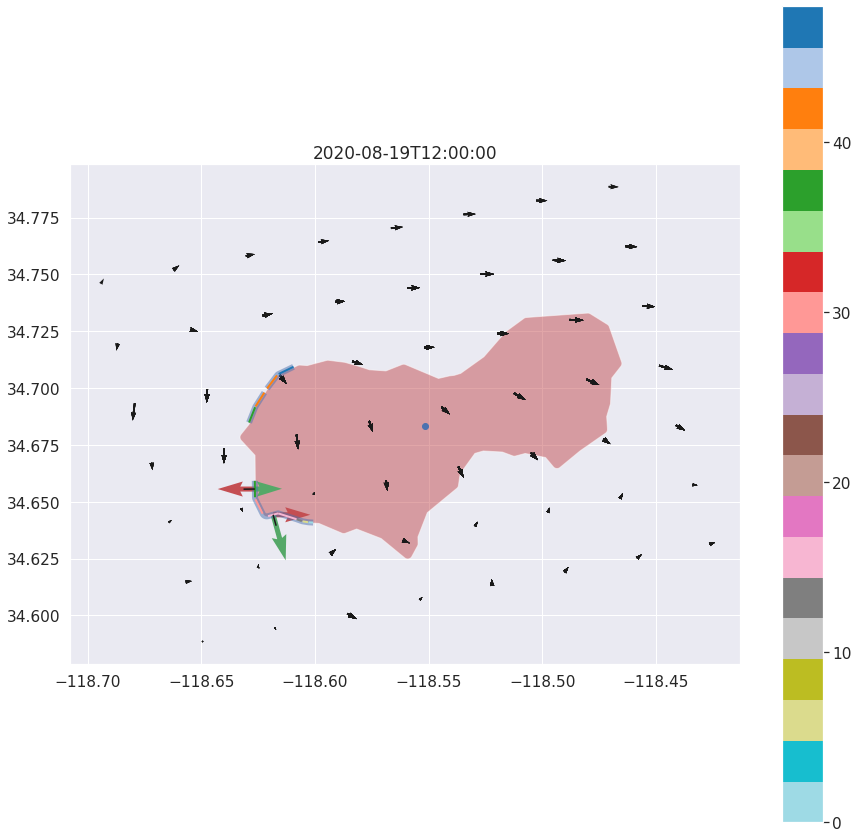

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/pytho

          minx       miny        maxx       maxy
37 -118.658143  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 40, grid_y: 1058, grid_yt: 40)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 261 262 263 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.78 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=42,43 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=41,44 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the

0.0


/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:670: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


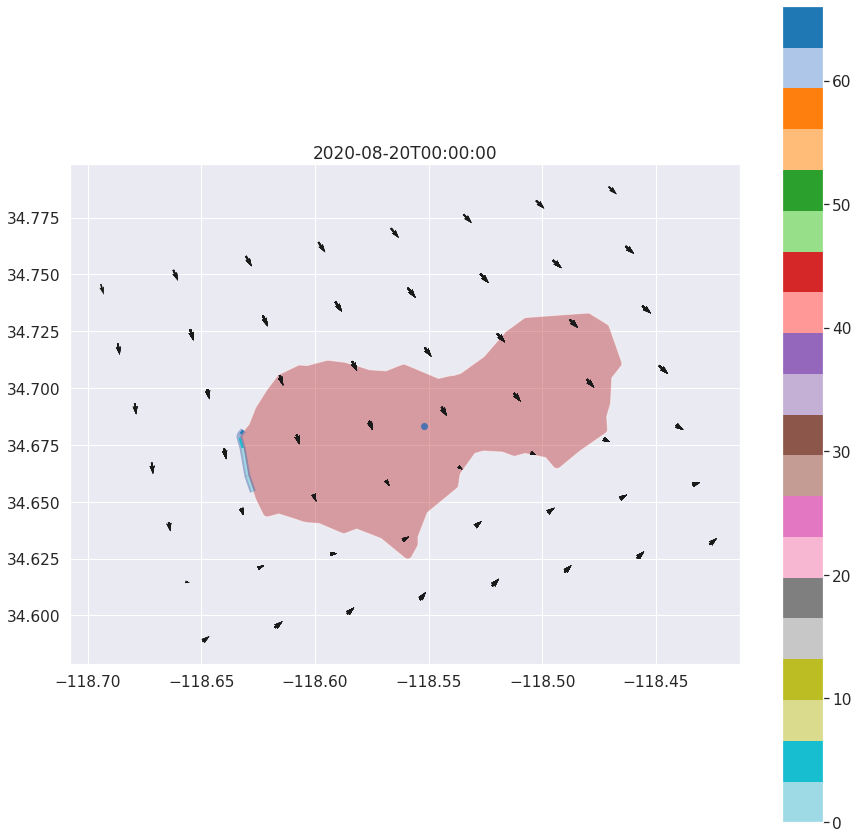

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
38 -118.659015  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 40, grid_y: 1058, grid_yt: 40)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 261 262 263 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 462 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.78 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=44,41 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=1,1 nx,ny=11,10 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data 

0.0


/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:686: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:686: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:738: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:751: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


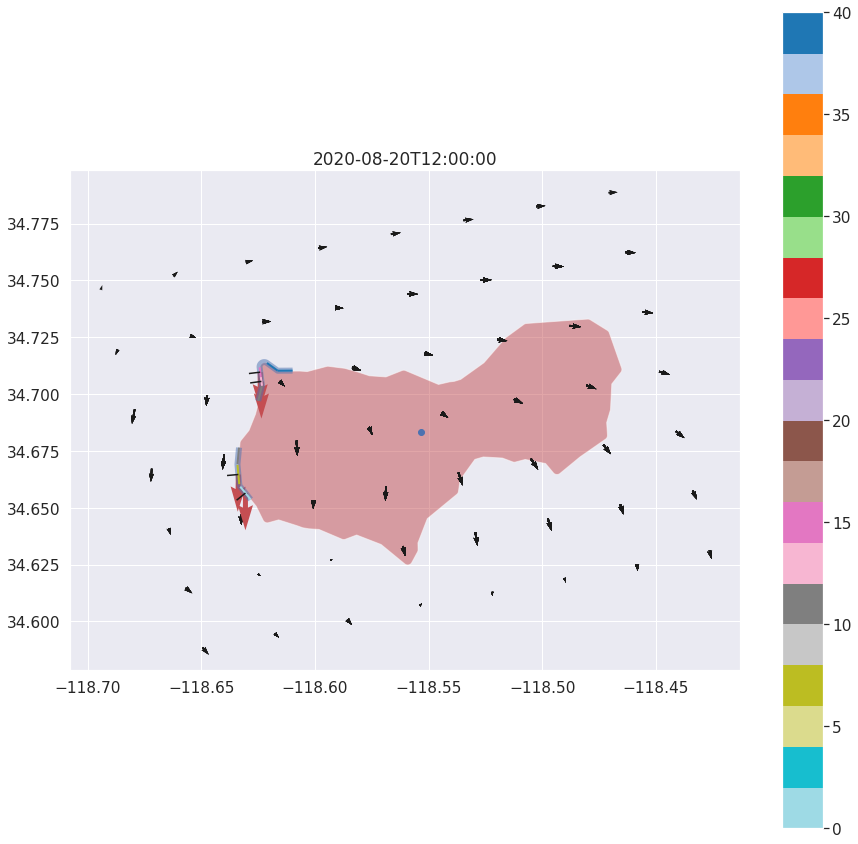

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
39 -118.674677  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 43, grid_y: 1058, grid_yt: 43)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 262 263 258 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 463 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

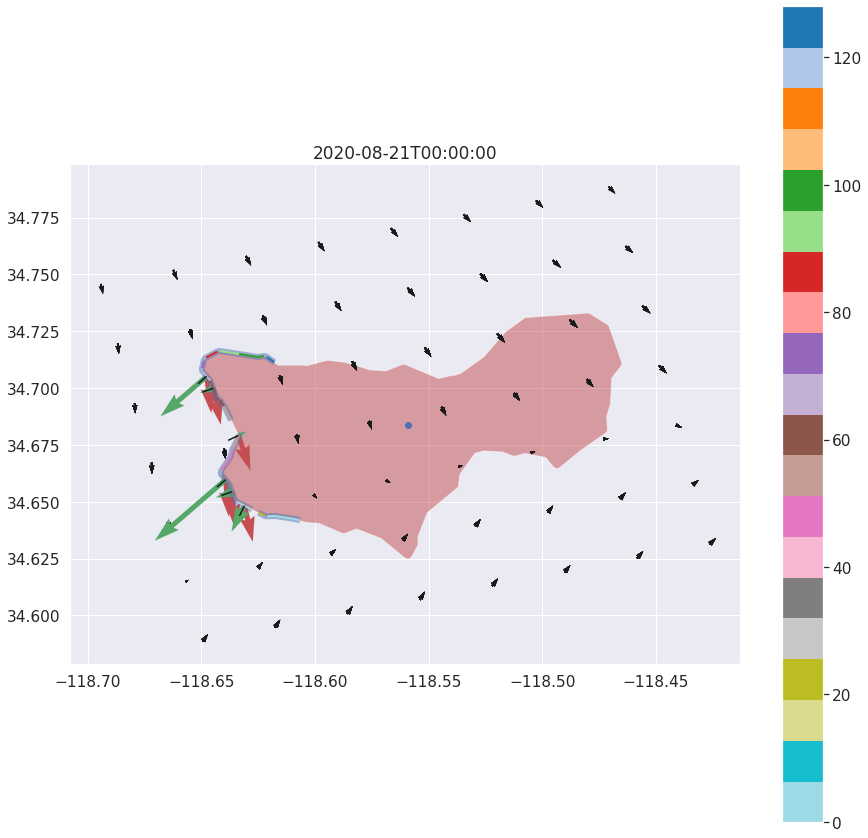

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

         minx       miny        maxx       maxy
40 -118.68796  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 45, grid_y: 1058, grid_yt: 45)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 262 263 258 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 463 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, grid_

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,46 m=2025 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.08334356080937674


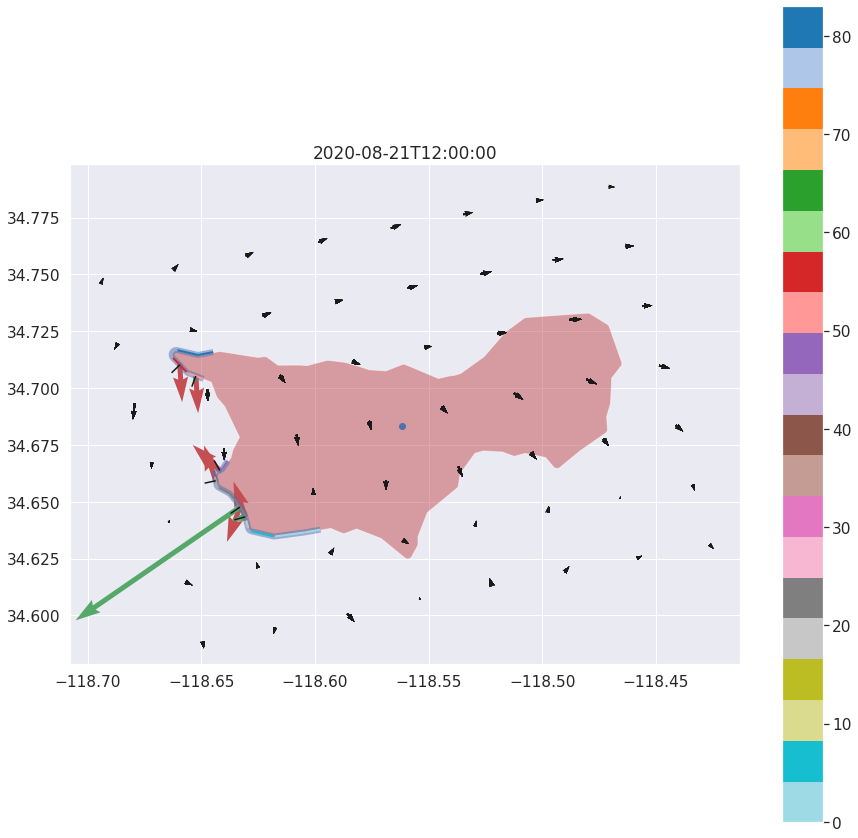

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:23: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launc

          minx       miny        maxx       maxy
41 -118.687964  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 45, grid_y: 1058, grid_yt: 45)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 262 263 258 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 463 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

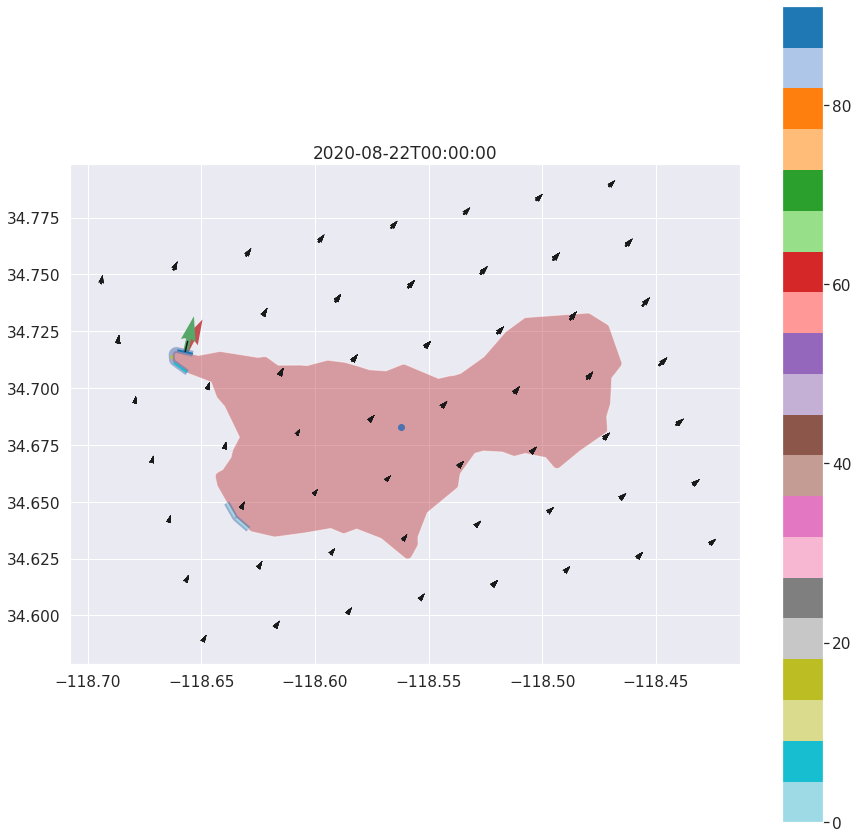

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/pytho

          minx       miny        maxx       maxy
42 -118.687964  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 45, grid_y: 1058, grid_yt: 45)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 262 263 258 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 463 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=47,48 m=2025 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.0


/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:686: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/matplotlib/quiver.py:686: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


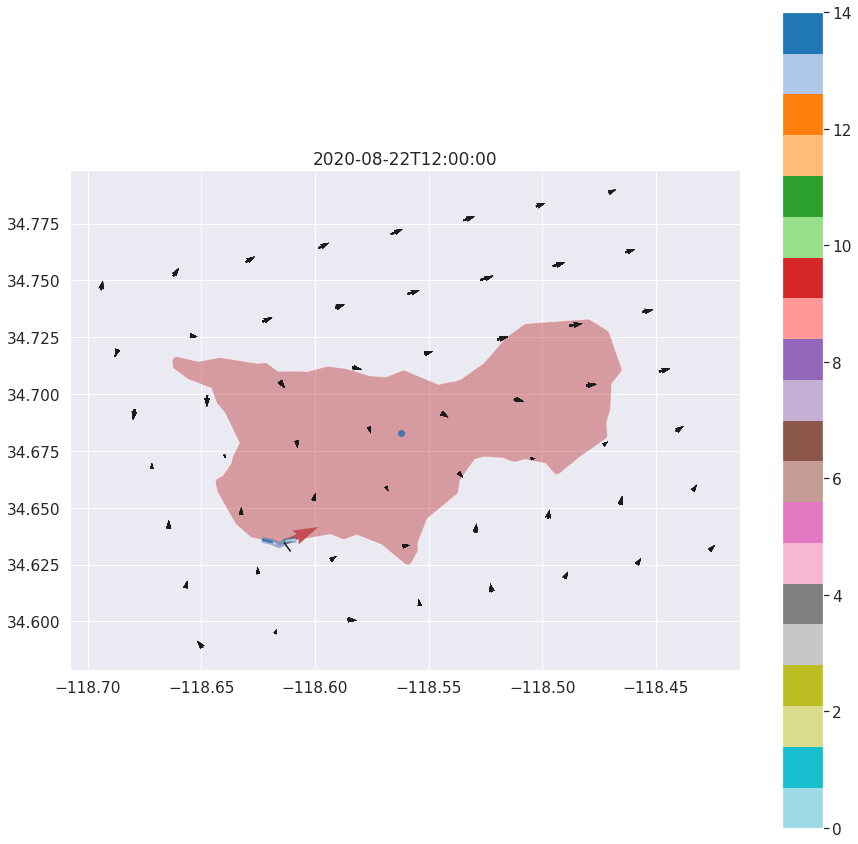

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/lthapa/anaconda3/envs/ML_py/lib/pytho

          minx       miny        maxx       maxy
43 -118.687964  34.600098 -118.440177  34.758216
<xarray.Dataset>
Dimensions:              (grid_x: 1798, grid_xt: 45, grid_y: 1058, grid_yt: 45)
Coordinates:
  * grid_x               (grid_x) int64 0 1 2 3 4 5 ... 1793 1794 1795 1796 1797
  * grid_y               (grid_y) int64 0 1 2 3 4 5 ... 1053 1054 1055 1056 1057
  * grid_xt              (grid_xt) int64 259 260 261 262 263 ... 262 263 258 259
  * grid_yt              (grid_yt) int64 457 457 457 457 457 ... 462 462 463 463
Data variables: (12/24)
    grid_lon             (grid_y, grid_x) float32 ...
    grid_lat             (grid_y, grid_x) float32 ...
    grid_lont            (grid_yt, grid_xt) float32 -118.6 -118.6 ... -118.6
    grid_latt            (grid_yt, grid_xt) float32 34.6 34.61 ... 34.75 34.76
    temp_2m              (grid_yt, grid_xt) float32 ...
    q_2m                 (grid_yt, grid_xt) float32 ...
    ...                   ...
    dd_term              (grid_yt, gri

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=49,46 m=2025 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=1,1 nx,ny=11,9 m=2025 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


KeyboardInterrupt: 

In [4]:
# perpindiculars are the same size!
test_fire_ids = [3525,3798,3763,3612,3482] #ABCDL order
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones, also ABCDL Order
fires_2020_fireline = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='fireline')
fires_2020_perimeter = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='perimeter')
fires_2020_pix = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='newfirepix')

start_time=12

fireline_lake = fires_2020_fireline[fires_2020_fireline['fireID']==test_fire_ids[4]]
perimeter_lake = fires_2020_perimeter[fires_2020_perimeter['fireID']==test_fire_ids[4]]
for ind in range(len(fireline_lake)): # the output of this for loop shoud be a df with directional HDW
    fline = fireline_lake.iloc[ind:ind+1] #fireline for the given timestep
    perim = perimeter_lake.iloc[ind:ind+1] #perimeter for the given timestep
    geom = fline.iloc[0].geometry #the fireline that we are splitting up
    
    if geom==None:
        continue #FOR NOW, COME BACK AND ADD A ROW TO THE FINAL OUTPUT WHEN IT'S DECIDED WHAT WILL GO THERE
    elif geom.geom_type=='LineString':
        segs_flat = segments(geom)
    elif geom.geom_type=='MultiLineString':
        segs_list = []
        for line in geom: #if a multipolygon
            segs_list.append(segments(line))
        segs_flat = [num for sublist in segs_list for num in sublist]
    segs = gpd.GeoDataFrame({'ind':np.arange(0,len(segs_flat)),
                             'time': np.repeat(fline.time,len(segs_flat)),
                            'geometry':segs_flat})
    segs = segs[segs.length>0.0005]
    
    perp_segs = find_perp_outside_segments(segs,0.005)

    time = perp_segs['time'].iloc[0] #can modify this later if it turns out the times are weird (maybe offset to 8/20:30??)
    timestr = pd.to_datetime(time).strftime('%Y%m%d%H')
    fname = '/data2/lthapa/ML_daily/pygraf/Processed_HRRR_'+ timestr+'.nc'
    hrrr = xr.open_dataset(fname)
    fire_poly_bounds = perim.buffer(0.025).bounds
    print(fire_poly_bounds)

    #open the wind data
    #subset the wind data
    grid_yt_sel, grid_xt_sel = np.where((hrrr['grid_lont']<fire_poly_bounds['maxx'].values)&
                                    (hrrr['grid_lont']>fire_poly_bounds['minx'].values)&
                                    (hrrr['grid_latt']<fire_poly_bounds['maxy'].values)&
                                    (hrrr['grid_latt']>fire_poly_bounds['miny'].values))
    hrrr = hrrr.sel(grid_yt=grid_yt_sel,grid_xt=grid_xt_sel)
    print(hrrr)

    
    #interpolate the u and v components, for direction with scipy
    f_u = si.interp2d(hrrr['grid_lont'].values.flatten(), 
                      hrrr['grid_latt'].values.flatten(), 
                      hrrr['uwind_10m'].values.flatten(), kind='linear')
    unew = np.array([f_u(perp_segs['x_mid'].values[kk], perp_segs['y_mid'].values[kk])[0] 
                     for kk in range(len(perp_segs))])
    
    f_v = si.interp2d(hrrr['grid_lont'].values.flatten(),
                      hrrr['grid_latt'].values.flatten(),
                      hrrr['vwind_10m'].values.flatten(), kind='linear')
    vnew = np.array([f_v(perp_segs['x_mid'].values[kk], perp_segs['y_mid'].values[kk])[0] 
                     for kk in range(len(perp_segs))])
    
    #interpolate the wind speed, for magnitude
    f_speed = si.interp2d(hrrr['grid_lont'].values.flatten(),
                      hrrr['grid_latt'].values.flatten(),
                      hrrr['wind_speed'].values.flatten(), kind='linear')
    speednew = np.array([f_speed(perp_segs['x_mid'].values[kk], perp_segs['y_mid'].values[kk])[0]
                for kk in range(len(perp_segs))])
    
    #get the unit vectors, for direction and save the wind speed
    perp_segs['u_wind_unit'] = unew/np.sqrt((unew**2)+(vnew**2))
    perp_segs['v_wind_unit'] = vnew/np.sqrt((unew**2)+(vnew**2))
    perp_segs['wind_speed'] = speednew
    
    #what portion of the unit vector is along the perpindicular? this uses cos(x) = u.v/||u||*||v|| vector law
    perp_segs['scale_factor'] = ((perp_segs['x']*perp_segs['u_wind_unit'])+
                                 (perp_segs['y']*perp_segs['v_wind_unit']))/(np.sqrt((perp_segs['x']**2)+(perp_segs['y']**2)))
    perp_segs['scale_factor'].iloc[np.where(perp_segs['scale_factor']<0)] =0
    
    #drop the rows where scale factor is 0
    perp_segs = perp_segs[perp_segs['scale_factor']>0]
    perp_segs['perp_wind_speed'] = perp_segs['scale_factor']*perp_segs['wind_speed']
    
    #drop the columns that have 0 for the scale factor
    perp_segs['fireline_length'] = perp_segs['fireline_geometry'].length
    perp_segs['fireline_length_fraction'] = perp_segs['fireline_length']/perp_segs['fireline_length'].sum()

    print((perp_segs['fireline_length_fraction']*perp_segs['perp_wind_speed']).sum()) #this should be the length-weighted wind speed
    
    fig,ax=plt.subplots(figsize=(15,15))
    fline.plot(ax=ax,linewidth=6,alpha=0.5)
    perim.plot(ax=ax,color='r',alpha=0.5)
    plt.scatter(perim['clon'],perim['clat'])
    segs.plot(ax=ax,column='ind',linewidth=2,legend=True,cmap='tab20_r')
    perp_segs.plot(ax=ax,color='k')
    plt.quiver(hrrr['grid_lont'], hrrr['grid_latt'], hrrr['uwind_10m'], hrrr['vwind_10m'])
    plt.quiver(perp_segs['x_mid'], perp_segs['y_mid'], 
               perp_segs['u_wind_unit'], 
               perp_segs['v_wind_unit'], 
               color='r')
    plt.quiver(perp_segs['x_mid'], perp_segs['y_mid'], 
               perp_segs['x']*perp_segs['perp_wind_speed'], 
               perp_segs['y']*perp_segs['perp_wind_speed'], color='g')

    plt.title(str(fline['time'].iloc[0]))
    plt.show()

In [ ]:
# perpindiculars are the same size!
test_fire_ids = [3525,3798,3763,3612,3482] #ABCDL order
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones, also ABCDL Order
fires_2020_fireline = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='fireline')
fires_2020_perimeter = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='perimeter')

start_time=12

fireline_lake = fires_2020_fireline[fires_2020_fireline['fireID']==test_fire_ids[4]]
perimeter_lake = fires_2020_perimeter[fires_2020_perimeter['fireID']==test_fire_ids[4]]

for ind in range(len(fireline_lake)): # the output of this for loop shoud be a df with directional HDW
    fline = fireline_lake.iloc[ind:ind+1] #fireline for the given timestep
    perim = perimeter_lake.iloc[ind:ind+1] #perimeter for the given timestep
    geom = fline.iloc[0].geometry
    
    if geom==None:
        continue #FOR NOW, COME BACK AND ADD A ROW TO THE FINAL OUTPUT WHEN IT'S DECIDED WHAT WILL GO THERE
    elif geom.geom_type=='LineString':
        segs_flat = segments(geom)
    elif geom.geom_type=='MultiLineString':
        segs_list = []
        for line in geom: #if a multipolygon
            segs_list.append(segments(line))
        segs_flat = [num for sublist in segs_list for num in sublist]
    segs = gpd.GeoDataFrame({'ind':np.arange(0,len(segs_flat)),
                             'time': np.repeat(fline.time,len(segs_flat)),
                            'geometry':segs_flat})
    segs = segs[segs.length>0.0005]
    
    perp_segs = find_perp_outside_segments(segs,0.005)
    print(perp_segs)

In [ ]:
# perpindiculars are the same size!
test_fire_ids = [3525,3798,3763,3612,3482] #ABCDL order
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones, also ABCDL Order
fires_2020_fireline = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='fireline')
fires_2020_perimeter = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='perimeter')
fires_2020_pix = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='newfirepix')
start_time=12

fireline_lake = fires_2020_fireline[fires_2020_fireline['fireID']==test_fire_ids[4]]
perimeter_lake = fires_2020_perimeter[fires_2020_perimeter['fireID']==test_fire_ids[4]]
pix_lake = fires_2020_pix[fires_2020_pix['fireID']==test_fire_ids[4]]

polygon_lake = gpd.read_file('./fire_polygons/lake_VIIRS_daily_12Z_day_start.geojson').to_crs('EPSG:4326')
print(polygon_lake)


"""
pix_lake.plot(column='time')
polygon_lake.plot(column='Local Day')"""

In [ ]:
#THIS IS A NEW WAY TO GET TO THE LOCAL DAY FROM THE UTC DAY
#print(pix_lake['time'])
doot = pd.to_datetime(pix_lake['time'].values)-timedelta(hours=12)

#print(doot.strftime('%Y-%m-%d'))
pix_lake['Local Day'] = doot.strftime('%Y-%m-%d')
pix_lake_dissolved = pix_lake.dissolve(by='Local Day').reset_index()

In [ ]:
pix_lake_dissolved.plot(column='Local Day')
polygon_lake.iloc[0:11].plot(column='Local Day')

In [ ]:
print(pix_lake_dissolved)

In [ ]:
#SAVE THIS, IT'S NEAREST NGITHBOR INTERP
#get the nearest neighbors
    rows = np.zeros(len(perp_segs))
    cols = np.zeros(len(perp_segs))
    uwinds = np.zeros(len(perp_segs))
    vwinds = np.zeros(len(perp_segs))

for kk in range(len(perp_segs)):
        dist = np.sqrt((hrrr['grid_latt'].values-perp_segs['y_mid'].values[kk])**2
                                +(hrrr['grid_lont'].values-perp_segs['x_mid'].values[kk])**2)
        row,col = np.where(dist==np.min(dist))
        rows[kk] = row[0]
        cols[kk] = col[0]
        uwinds[kk] = hrrr['uwind_10m'].values[row,col][0]
        vwinds[kk] = hrrr['vwind_10m'].values[row,col][0]

In [ ]:
"""print(hrrr.sel(grid_latt=perp_segs['y_mid'].values,
               grid_xt=perp_segs['x_mid'].values,
               method="nearest")['grid_latt'])"""

#eventually want to use interp (time=blah, lat=blah, lon=blah)


print(len(perp_segs))

#load the associated HRRR data as an xarray
#select the data at the points (nearest neighbor indexing is what xarray does automatically)

time = perp_segs['time'].iloc[0]
timestr = pd.to_datetime(time).strftime('%Y%m%d%H')
fname = '/data2/lthapa/ML_daily/pygraf/Processed_HRRR_'+ timestr+'.nc'

hrrr = xr.open_dataset(fname)
#hrrr = hrrr.assign_coords(grid_latt=(('grid_yt', 'grid_xt'), hrrr['grid_latt'].values))
#hrrr = hrrr.assign_coords(grid_lont=(('grid_yt', 'grid_xt'), hrrr['grid_lont'].values))
grid_yt_sel, grid_xt_sel = np.where((hrrr['grid_lont']<fire_poly_bounds['maxx'].values)&
                                    (hrrr['grid_lont']>fire_poly_bounds['minx'].values)&
                                    (hrrr['grid_latt']<fire_poly_bounds['maxy'].values)&
                                    (hrrr['grid_latt']>fire_poly_bounds['miny'].values))
hrrr = hrrr.sel(grid_yt=grid_yt_sel,grid_xt=grid_xt_sel)
print(hrrr)
f = si.interp2d(hrrr['grid_lont'], hrrr['grid_latt'], hrrr['uwind_10m'], kind='cubic')

znew = f(perp_segs['x_mid'], perp_segs['y_mid'])
print(znew.shape)
#print(hrrr.interp(grid_lont=1.1,grid_yt=5.6))
#y = xr.DataArray(rows,dims='z')
#x = xr.DataArray(cols,dims='z')

#hrrr_sub = hrrr.sel(grid_xt=cols,grid_yt=rows)
#print(hrrr_sub['grid_latt'])

## Check timing of polygons (mine vs Chen's)

In [ ]:
# perpindiculars are the same size!
test_fire_ids = [3525,3798,3763,3612,3482] #ABCDL order
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT','CREEK', 'DOLAN','LAKE'] #only california ones, also ABCDL Order
fires_2020_fireline = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='fireline')
fires_2020_perimeter = gpd.read_file('./Largefire/LargeFires_2020.gpkg', layer='perimeter')

lake_thapa = gpd.read_file('./fire_polygons/lake_VIIRS_daily_12Z_day_start.geojson').to_crs('EPSG:4326')
start_time=12

fireline_lake = fires_2020_fireline[fires_2020_fireline['fireID']==test_fire_ids[4]]
perimeter_lake = fires_2020_perimeter[fires_2020_perimeter['fireID']==test_fire_ids[4]]

In [ ]:
fireline_lake['day'] = [fireline_lake['time'].iloc[jj][0:10] for jj in range(len(fireline_lake))]
fireline_lake = fireline_lake[fireline_lake['day']<'2020-08-16']
fireline_lake


In [ ]:
lake_thapa = lake_thapa[lake_thapa['Local Day']<'2020-08-16']
lake_thapa

In [ ]:
fig,ax=plt.subplots(figsize=(15,15))
lake_thapa.plot(ax=ax,column='Local Day')
fireline_lake.plot(ax=ax,column='time',legend=True)
plt.show()